In [78]:
import pandas as pd
import numpy as np



In [79]:
col = ['Data','Time','Value','Labels']
data = pd.read_csv('33_data.csv', skiprows=1, header=1, names=col)
data.head(10)

,Data,Time,Value,Labels
0,07-31-1990,22:51,71,0
1,07-31-1990,22:51,33,3
2,07-31-1990,22:51,34,7
3,8/1/90,6:25,58,80
4,8/1/90,6:57,33,6
5,8/1/90,11:39,60,72
6,8/1/90,11:58,33,5
7,8/1/90,11:58,70,0
8,8/1/90,18:07,62,92
9,8/1/90,18:09,72,0


In [82]:

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right 
        self.info_gain = info_gain
        self.value = value 

class DecisionTree():
    def __init__(self, min_sample_split=2, max_dept=2):
        self.root = None 
        self.min_sample_split = min_sample_split
        self.max_dept = max_dept

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_sample_split and curr_depth <= self.max_dept:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split['info_gain'] > 0:
                left_subtree = self.build_tree(best_split['data_left'], curr_depth+1)
                right_subtree = self.build_tree(best_split['data_right'], curr_depth+1)
                return Node(best_split['feature_index'], best_split['threshold'], left_subtree, right_subtree, best_split['info_gain'])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, data, num_samples, num_features):
        best_split = {}
        max_info_gain = -float('inf')
        for feature_index in range(num_features):
            feature_value = data[:, feature_index]
            possible_thresholds = np.unique(feature_value)
            for threshold in possible_thresholds:
                data_left, data_right = self.split(data, feature_index, threshold)
                if len(data_left) > 0 and len(data_right) > 0:
                    y, left_y, right_y = data[:, -1], data_left[:, -1], data_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, 'gini')
                    if curr_info_gain > max_info_gain:
                        best_split['feature_index'] = feature_index
                        best_split['threshold'] = threshold
                        best_split['data_left'] = data_left
                        best_split['data_right'] = data_right
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain
        return best_split

    def split(self, data, feature_index, threshold):
        data_left = np.array([row for row in data if row[feature_index] <= threshold])
        data_right = np.array([row for row in data if row[feature_index] > threshold])
        return data_left, data_right

    def information_gain(self, parent, l_child, r_child, mode='entropy'):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == 'gini':
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
        return gain

    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        class_labels = np.unique(y)
        gini = 0 
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def calculate_leaf_value(self, y):
        y = list(y)
        return max(y, key=y.count)

    def print_tree(self, tree=None, indent=''):
        if not tree:
            tree = self.root 
        if tree.value is not None:
            print(tree.value)
        else:
            print('X_' + str(tree.feature_index), '<=', tree.threshold, '?', tree.info_gain)
            print('%sleft:' % (indent), end='')
            self.print_tree(tree.left, indent + '  ')
            print('%sright:' % (indent), end='')
            self.print_tree(tree.right, indent + '  ')

    def fit(self, X, y):
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(data)

    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions

    def make_prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Instantiate the Decision Tree with specified parameters
classifier = DecisionTree(min_sample_split=3, max_dept=3)

# Fit the model to training data
classifier.fit(X_train, Y_train)

# Print the tree
classifier.print_tree()

y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
print('Decision Tree Accuracy:', accuracy_score(Y_test,y_pred))



X_2 <= 64 ? 0.1734423431450176
left:X_2 <= 34 ? 0.04678222653046493
  left:X_1 <= 12:59 ? 0.08166089056920811
    left:X_0 <= 08-14-1990 ? 0.13722222222222236
      left:6
      right:5
    right:X_2 <= 33 ? 0.05719186374391594
      left:2
      right:7
  right:X_1 <= 12:09 ? 0.01368499677002577
    left:X_0 <= 08-14-1990 ? 0.10444444444444445
      left:262
      right:60
    right:X_1 <= 12:17 ? 0.016300781322585833
      left:197
      right:86
right:0
Decision Tree Accuracy: 0.31666666666666665


In [81]:


class RandomForest:
    def __init__(self, n_estimators=100, min_sample_split=2, max_dept=2, random_state=None):
        self.n_estimators = n_estimators
        self.min_sample_split = min_sample_split
        self.max_dept = max_dept
        self.random_state = random_state
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            tree = DecisionTree(min_sample_split=self.min_sample_split, max_dept=self.max_dept)
            indices = np.random.choice(len(X), len(X), replace=True)
            tree.fit(X[indices], y[indices].flatten())  
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)


classifier = RandomForest()
classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
print('Random Forest Accuracy:', accuracy)






Random Forest Accuracy: 0.23333333333333334


In [83]:
class GradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # Initialize the model with the mean value of y
        self.initial_prediction = np.mean(y)
        y_pred = np.full(len(y), self.initial_prediction)

        # Update the model with residual errors
        for _ in range(self.n_estimators):
            residual = y - y_pred
            tree = DecisionTree(max_dept=self.max_depth)
            tree.fit(X, residual)
            self.trees.append(tree)
            # Update predictions with the output of the new tree multiplied by the learning rate
            y_pred += self.learning_rate * tree.predict(X)

    def predict(self, X):
        y_pred = np.full(len(X), self.initial_prediction)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

# Instantiate the Gradient Boosting model with specified parameters
classifier = GradientBoostingClassifier()

# Fit the model to training data
classifier.fit(X_train, Y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(Y_test, y_pred)
print("Gradient Boosting Accuracy:", accuracy)


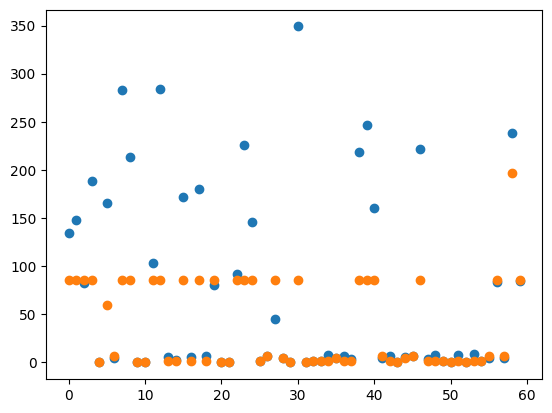

In [77]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1,1)
ax.plot(Y_test, 'o', label = 'Y_test')
ax.plot(y_pred, 'o', label = 'Y_pred')
plt.show()

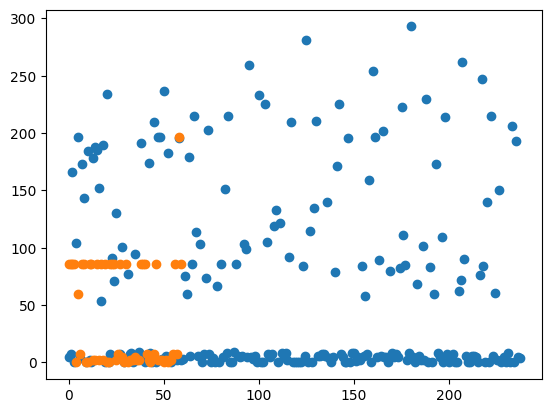

In [71]:
_, ax = plt.subplots(1,1)
ax.plot(Y_train, 'o', label = 'Y_train')
ax.plot(y_pred, 'o', label = 'Y_pred')
plt.show()

In [99]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right 
        self.info_gain = info_gain
        self.value = value 

class DecisionTree():
    def __init__(self, min_sample_split=2, max_dept=2):
        self.root = None 
        self.min_sample_split = min_sample_split
        self.max_dept = max_dept

    def build_tree(self, data, curr_depth=0):
        X, Y = data[:, :-1], data[:, -1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_sample_split and curr_depth <= self.max_dept:
            data_split = self.split_data(data, num_samples, num_features)
            if data_split['info_gain'] > 0:
                left_subtree = self.build_tree(data_split['data_left'], curr_depth+1)
                right_subtree = self.build_tree(data_split['data_right'], curr_depth+1)
                return Node(data_split['feature_index'], data_split['threshold'], left_subtree, right_subtree, data_split['info_gain'])
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def split_data(self, data, num_samples, num_features):
        data_split = {}
        max_info_gain = -float('inf')
        for feature_index in range(num_features):
            feature_value = data[:, feature_index]
            possible_thresholds = np.unique(feature_value)
            for threshold in possible_thresholds:
                data_left, data_right = self.split_dataset(data, feature_index, threshold)
                if len(data_left) > 0 and len(data_right) > 0:
                    y, left_y, right_y = data[:, -1], data_left[:, -1], data_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, 'gini')
                    if curr_info_gain > max_info_gain:
                        data_split['feature_index'] = feature_index
                        data_split['threshold'] = threshold
                        data_split['data_left'] = data_left
                        data_split['data_right'] = data_right
                        data_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain
        return data_split
    def split_dataset(self, data, feature_index, threshold):
        data_left = np.array([row for row in data if row[feature_index] <= threshold])
        data_right = np.array([row for row in data if row[feature_index] > threshold])
        return data_left, data_right

    def information_gain(self, parent, l_side, r_side, mode='entropy'):
        left_l = len(l_side) / len(parent)
        right_r = len(r_side) / len(parent)
        if mode == 'gini':
            gain = self.gini_index(parent) - (left_l * self.gini_index(l_side) + right_r * self.gini_index(r_side))
        else:
            gain = self.entropy(parent) - (left_l * self.entropy(l_side) + right_r * self.entropy(r_side))
        return gain

    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy

    def gini_index(self, y):
        class_labels = np.unique(y)
        gini = 0 
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    def calculate_leaf_value(self, y):
        y = list(y)
        return max(y, key=y.count)

    def print_tree(self, tree=None, indent=''):
        if not tree:
            tree = self.root 
        if tree.value is not None:
            print(tree.value)
        else:
            print('x_' + str(tree.feature_index), '<=', tree.threshold, '->', tree.info_gain)
            print('%sleft: ' % (indent), end='')
            self.print_tree(tree.left, indent + '  ')
            print('%sright: ' % (indent), end='')
            self.print_tree(tree.right, indent + '  ')

    def fit(self, X, y):
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.root = self.build_tree(data)

    def predict(self, X):
        predictions = [self.prediction(x, self.root) for x in X]
        return predictions
    def prediction(self, x, tree):
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.prediction(x, tree.left)
        else:
            return self.prediction(x, tree.right)

X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=41)

classifier = DecisionTree(min_sample_split=3, max_dept=3)
classifier.fit(X_train, Y_train)
classifier.print_tree()

y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
print('Decision Tree Accuracy:', accuracy_score(Y_test,y_pred))




x_2 <= 64 -> 0.1734423431450176
left: x_2 <= 34 -> 0.04678222653046493
  left: x_1 <= 12:59 -> 0.08166089056920811
    left: x_0 <= 08-14-1990 -> 0.13722222222222236
      left: 6
      right: 5
    right: x_2 <= 33 -> 0.05719186374391594
      left: 2
      right: 7
  right: x_1 <= 12:09 -> 0.01368499677002577
    left: x_0 <= 08-14-1990 -> 0.10444444444444445
      left: 262
      right: 60
    right: x_1 <= 12:17 -> 0.016300781322585833
      left: 197
      right: 86
right: 0
Decision Tree Accuracy: 0.31666666666666665
